# Task 2

## Import Libraries

In [1]:
import sys
sys.path.append('../src')

import matplotlib.pyplot as plt
import numpy as np
import logging
import pandas as pd
from tqdm import tqdm

from environment_gym import TrafficEnvironment
from task2_environment import CustomTrafficEnvironment
from task2_agents import RuleBasedAgent, TemporalDifference

c:\Users\danie\OneDrive - Singapore Management University\SMU Singapore\Academics\Aug 2024\CS609_ReinforcementLearning\Project\LaneSwitchRL-Simulation\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Rule-Based Agent

### Evaluation

In [2]:
def evaluate_agent(agent, env, num_episodes=10, starting_lane = 1):
    all_episode_rewards = []
    all_timesteps = []
    truncated_count = 0

    for episode in tqdm(range(num_episodes)):
        episode_rewards = []
        
        options = {
            'starting_lane': starting_lane
        }
        state, _ = env.reset(options=options)
        terminated = False
        truncated = False
        cumulative_reward = 0
        timestep = 0
        action_mapping = {0: 'left', 1: 'stay', 2: 'right'}

        while not terminated and not truncated:
            action = agent.choose_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            cumulative_reward += reward
            state = next_state
            timestep += 1
            
            # Store rewards at each timestep for this episode
            episode_rewards.append(cumulative_reward)

            if truncated:
                truncated_count += 1
                break

        # Append results for each episode
        all_episode_rewards.append(cumulative_reward)
        if not truncated:
            all_timesteps.append(timestep)

    print(f"Truncated episodes: {truncated_count}")
    
    return all_episode_rewards, all_timesteps

def plot_eval_metrics(all_episode_rewards, all_timesteps, window_size=10):
    """
    Plot cumulative rewards and timesteps to termination with a rolling mean.

    Args:
    - all_episode_rewards (list of lists): Cumulative rewards for each episode.
    - all_timesteps (list): Number of timesteps to termination for each episode.
    - window_size (int): Window size for rolling mean.
    """
    # Compute rolling mean for cumulative rewards across episodes
    rolling_rewards = pd.DataFrame(all_episode_rewards).mean(axis=0).rolling(window_size).mean()
    # Compute rolling mean for timesteps to termination
    rolling_timesteps = pd.Series(all_timesteps).rolling(window_size).mean()

    # Plot the cumulative rewards with rolling mean
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(rolling_rewards, label='Cumulative Reward (Rolling Mean)')
    plt.xlabel('Timesteps')
    plt.ylabel('Cumulative Reward')
    plt.title(f'Cumulative Rewards Over Episodes (Rolling Mean - Window Size: {window_size})')
    plt.legend()

    # Plot the timesteps to termination with rolling mean
    plt.subplot(1, 2, 2)
    plt.plot(rolling_timesteps, label='Timesteps to Termination (Rolling Mean)')
    plt.xlabel('Episode')
    plt.ylabel('Timesteps')
    plt.title(f'Timesteps to Termination (Rolling Mean - Window Size: {window_size})')
    plt.legend()

    plt.tight_layout()
    plt.show()

### Fastest Adjacent Lane

In [3]:
# Create the environment
env = CustomTrafficEnvironment(max_time_steps=10000, logging_enabled=False)
# Evaluate each strategy
strategy = 'fastest_adjacent'
rewards_dict = {}
timesteps_dict = {}

agent = RuleBasedAgent(strategy=strategy)
# episode_rewards, checkpoint_rewards, timesteps_to_termination = evaluate_agent(agent, env)
all_episode_rewards, all_timesteps = evaluate_agent(agent, env, num_episodes=500)
rewards_dict['Fastest Adjacent Lane Agent'] = all_episode_rewards
timesteps_dict['Fastest Adjacent Lane Agent'] = all_timesteps
# env.logger.info("\n"*5)

100%|██████████| 500/500 [00:16<00:00, 31.13it/s]

Truncated episodes: 303


In [4]:
print(f'Average cumulative rewards for Fastest Adjacent Lane strategy: {round(np.mean(rewards_dict['Fastest Adjacent Lane Agent']))}')
print(f'Average timesteps to termination for Fastest Adjacent Lane strategy: {round(np.mean(timesteps_dict["Fastest Adjacent Lane Agent"]))}')

Average cumulative rewards for Fastest Adjacent Lane strategy: -2883
Average timesteps to termination for Fastest Adjacent Lane strategy: 229


### Same Lane

In [5]:
# Create the environment
env = CustomTrafficEnvironment(max_time_steps=10000, logging_enabled=False)

for i in range(5):
    env.logger.info(f"Evaluating Agent {i+1}")
    agent = RuleBasedAgent(strategy='stay')
    all_episode_rewards, all_timesteps = evaluate_agent(agent, env, num_episodes=500, starting_lane=i+1)
    rewards_dict[f'Same Lane Agent {i+1}'] = all_episode_rewards
    timesteps_dict[f'Same Lane Agent {i+1}'] = all_timesteps

100%|██████████| 500/500 [00:21<00:00, 23.70it/s]


Truncated episodes: 330


100%|██████████| 500/500 [00:21<00:00, 23.32it/s]


Truncated episodes: 340


100%|██████████| 500/500 [00:21<00:00, 22.78it/s]


Truncated episodes: 309


100%|██████████| 500/500 [00:21<00:00, 23.37it/s]


Truncated episodes: 331


100%|██████████| 500/500 [00:21<00:00, 23.04it/s]

Truncated episodes: 332


In [6]:
for i in range(5):
    print(f'Average cumulative rewards for Same Lane Agent {i+1}: {round(np.mean(rewards_dict[f"Same Lane Agent {i+1}"]))}')
    print(f'Average timesteps to termination for Same Lane Agent {i+1}: {round(np.mean(timesteps_dict[f"Same Lane Agent {i+1}"]))}')
    print('\n')

Average cumulative rewards for Same Lane Agent 1: -3882
Average timesteps to termination for Same Lane Agent 1: 296


Average cumulative rewards for Same Lane Agent 2: -3755
Average timesteps to termination for Same Lane Agent 2: 308


Average cumulative rewards for Same Lane Agent 3: -3634
Average timesteps to termination for Same Lane Agent 3: 318


Average cumulative rewards for Same Lane Agent 4: -3621
Average timesteps to termination for Same Lane Agent 4: 306


Average cumulative rewards for Same Lane Agent 5: -4074
Average timesteps to termination for Same Lane Agent 5: 322




## Value-based Agent

### TD-Lambda

Best Parameters: 'alpha': 0.00034730495205915015, 'gamma': 0.8736754469200055, 'epsilon_decay': 0.9974883518154749, 'epsilon_min': 0.07171493690427357, 'lambd': 0.9979639828730743

{'alpha': 0.0006007024756734379, 'gamma': 0.3562072501879241, 'epsilon_decay': 0.9575282722270251, 'epsilon_min': 0.035559819115941076, 'lambd': 0.24904922861472512}

100%|██████████| 500/500 [00:34<00:00, 14.63it/s]


Training statistics saved to ./logs/task2/training_logs.json
Truncated episodes: 417
Sum of total rewards = -1642415.4999999995
Average total reward per episode = -3284.8309999999997
Average steps per episode = 238.59036144578315


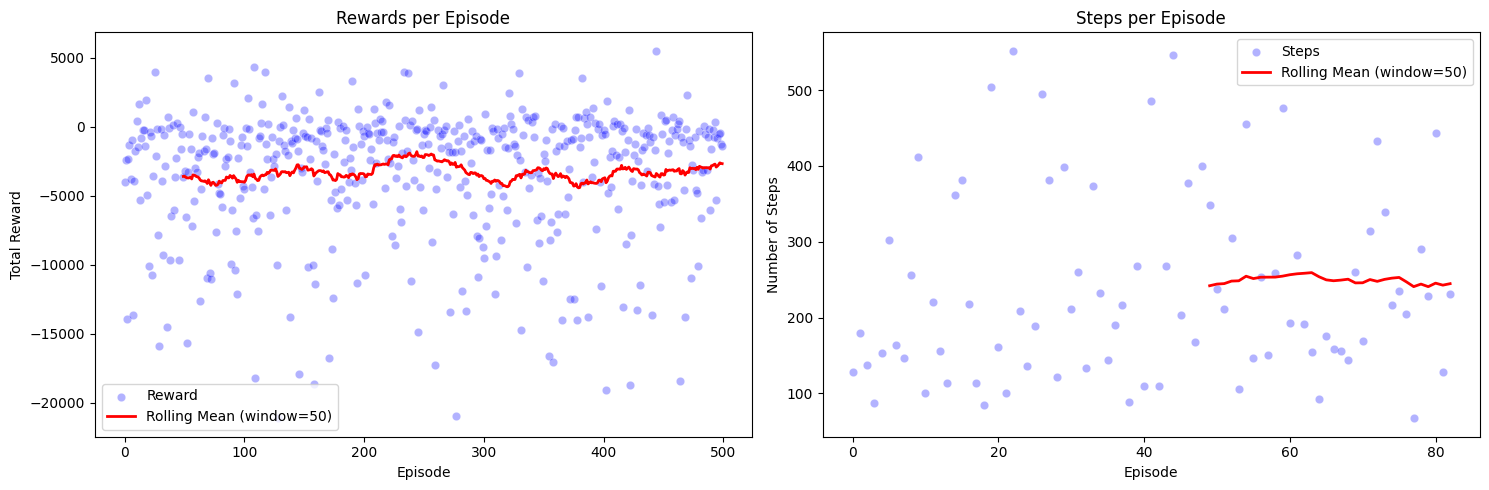

In [3]:
# Create the environment
env = CustomTrafficEnvironment(max_time_steps=10000, logging_enabled=False)

td_lambda = TemporalDifference(env, oiv = 0.1, alpha=1e-4, epsilon=1.0, lambd=0, gamma=0.5, epsilon_decay=0.9575, epsilon_min=0.1)
total_reward_list, total_steps_list = td_lambda.train(num_episodes = 500, on_policy = False, save_model = False)
total_rew = sum(total_reward_list)
avg_rew = np.mean(total_reward_list)
avg_steps = np.mean(total_steps_list)

print(f'Sum of total rewards = {total_rew}')
print(f'Average total reward per episode = {avg_rew}')
print(f'Average steps per episode = {avg_steps}')

# plot training metrics
td_lambda.plot_training_metrics(window_size=50)
plt.show()

### Analysis

In [4]:
print(len(td_lambda.Q))

1224


State Space Size = 5 x 5 x 5 (Clearance Rates) x 5 (Risk Factor) x 2 (Over Speed Limit) x 3 (Actions) = 3,750

In [11]:
5*5*5*5*2*3

3750

In [5]:
# Run the analyses
lane_speed_preference_results, high_risk_mismatch_percentage, low_risk_mismatch_percentage = td_lambda.analyze_lane_speed_preference()
risk_factor_stay_preference_results = td_lambda.analyze_risk_factor_stay_preference()

c:\Users\danie\OneDrive - Singapore Management University\SMU Singapore\Academics\Aug 2024\CS609_ReinforcementLearning\Project\LaneSwitchRL-Simulation\notebooks\../src\task2_agents.py:415: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_risk_df['Highest Q-value Action'] = high_risk_df[['Left', 'Stay', 'Right']].idxmax(axis=1)


In [6]:
print(f"\nPercentage of mismatches in high-risk cases: {high_risk_mismatch_percentage:.2f}%")
print(f"Percentage of mismatches in low-risk cases: {low_risk_mismatch_percentage:.2f}%")


Percentage of mismatches in high-risk cases: 44.31%
Percentage of mismatches in low-risk cases: 55.04%


In [7]:
print("\nRisk Factor and Stay Preference Analysis:")
risk_factor_stay_preference_results


Risk Factor and Stay Preference Analysis:


{'Total High Risk Cases': 510,
 'Stay Preference in High Risk': np.int64(278),
 'Stay Preference Percentage': np.float64(54.509803921568626)}

In [8]:
q_df = td_lambda.q_table_to_dataframe()
q_df.head()

,Current Lane Rate,Left Lane Rate,Right Lane Rate,Risk Factor,Over Speed Limit,Left,Stay,Right
0,4,0,4,0,0,0.124066,0.138911,0.835365
1,4,4,4,0,0,0.123921,1.376159,0.143315
2,4,3,4,0,0,0.103490,0.112783,0.274947
3,4,2,4,0,0,0.104946,0.241181,0.101877
4,3,2,3,0,0,0.101626,0.100000,0.184316


In [ ]:
q_df.loc[q_df['left']]

1224

In [22]:
lanes = ['Current', 'Left', 'Right']
print(lanes)
other_lanes = lanes.copy().remove('Current')
print(other_lanes)

['Current', 'Left', 'Right']
None


In [17]:
lanes = ['Current', 'Left', 'Right']
for fast_lane in lanes:
    other_lanes = lanes.copy().remove(fast_lane)
    total = q_df.loc[((q_df[f'{fast_lane} Lane Rate'] < q_df[f'{other_lanes[0]} Lane Rate']) & (q_df[f'{fast_lane} Lane Rate'] < q_df[f'{other_lanes[1]} Lane Rate'])) & (q_df['Risk Factor'] < 5)].shape[0]
    rate = q_df.loc[((q_df[f'{fast_lane} Lane Rate'] < q_df[f'{other_lanes[0]} Lane Rate']) & (q_df[f'{fast_lane} Lane Rate'] < q_df[f'{other_lanes[1]} Lane Rate'])) & (q_df['Risk Factor'] < 5) \
    & ((q_df[f'{fast_lane if fast_lane != 'Current' else 'Stay'}'] > q_df[f'{other_lanes[0] if other_lanes[0] != 'Current' else 'Stay'}']) \
        & (q_df[f'{fast_lane if fast_lane != 'Current' else 'Stay'}'] > q_df[f'{other_lanes[1] if other_lanes[1] != 'Current' else 'Stay'}']))].shape[0]
    rate = rate/q_df.shape[0]
    print(f"Number of cases where the {fast_lane} lane has the highest value for low risk: {rate}")

TypeError: 'NoneType' object is not subscriptable

### Evaluation

In [19]:
td_lambda.Env.enable_logging()

In [5]:
# Evaluate the agent in inference mode
all_rewards, all_steps = td_lambda.evaluate(num_episodes=500)

# Print the results
print(f"Average cumulative rewards for TD-Lambda Agent: {round(np.mean(all_rewards))}")
print(f"Average timesteps to termination for TD-Lambda Agent: {round(np.mean(all_steps))}")

100%|██████████| 500/500 [00:32<00:00, 15.35it/s]

Training statistics saved to ./logs/task2/training_logs.json
Average cumulative rewards for TD-Lambda Agent: -3759
Average timesteps to termination for TD-Lambda Agent: 148


In [9]:
td_lambda.Env.disable_logging()

In [6]:
print(f"Average cumulative rewards for TD-Lambda Agent: {round(np.mean(all_rewards))}")
print(f"Average timesteps to termination for TD-Lambda Agent: {round(np.mean(all_steps))}")

Average cumulative rewards for TD-Lambda Agent: -4913
Average timesteps to termination for TD-Lambda Agent: 184


### Hyperparameter Tuning

In [8]:
hyperparameter_space = {
    'alpha': [1e-4, 1e-2],           # Learning rate range (log scale)
    'gamma': [0.1, 0.99],            # Discount factor range
    'epsilon_decay': [0.9, 0.9999],   # Epsilon decay range
    'epsilon_min': [0.01, 0.1],      # Minimum epsilon range
    'lambd': [0, 0.9]             # Lambda range for eligibility traces
}
env = CustomTrafficEnvironment(max_time_steps=10000, logging_enabled=False)
td_lambda = TemporalDifference(env)
# Run hyperparameter tuning
best_agent, best_params = td_lambda.hyperparameter_tuning(hyperparameter_space=hyperparameter_space, episodes=500, n_trials=30, on_policy=False)

[I 2024-11-05 01:53:08,568] A new study created in memory with name: no-name-6982d27d-ca3c-4d80-b920-b219700b9f93
100%|██████████| 500/500 [11:49<00:00,  1.42s/it]
[W 2024-11-05 02:04:58,385] Trial 0 failed with parameters: {'alpha': 0.0005604090760077114, 'gamma': 0.580588604955087, 'epsilon_decay': 0.9112669188092877, 'epsilon_min': 0.09757174374127979, 'lambd': 0.009376513888873728} because of the following error: ValueError('setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.').
Traceback (most recent call last):
  File "c:\Users\danie\OneDrive - Singapore Management University\SMU Singapore\Academics\Aug 2024\CS609_ReinforcementLearning\Project\LaneSwitchRL-Simulation\.venv\Lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "c:\Users\danie\OneDrive - Singapore Management University\S

Training statistics saved to ./logs/task2/training_logs.json
Truncated episodes: 410


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.